In [1]:
# auto reload external package setting
%load_ext autoreload
%autoreload 2

# Global Settings

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cantera as ct
from tqdm.auto import tqdm  # to show progress bar

# figure plotting settings
plt.style.use("default")
plt.rc("figure", figsize=[5, 5])
plt.rc("font", size=14, family="Arial")
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("xtick", labelsize=11)
plt.rc("ytick", labelsize=11)
plt.rc("lines", linewidth=2)

# Counterflow

In [3]:
gas = ct.Solution("../mechanism/FFCM2_CH2O.yaml")  # load the gas phase mechanism

tin_o = 298.15  # oxidizer inlet temperature (K)
tin_f = 700.0  # fuel gas phase inlet temperature (K)
p = 0.1e6  # pressure (Pa) = 0.1 MPa
comp_o = "O2:1"  # oxidizer inlet composition, pure oxygen
comp_f = "CH2O:1"  # fuel inlet composition, pure formaldehyde after POM decomposition
width = 0.0043  # separation distance between two nozzles (m) = 4.3 mm

h_solid = -171.25e3  # enthaly of formation of solid POM at 298K (J/mol)
rho_solid = 1.42e3  # solid POM density (J/mol)
mw = gas.molecular_weights[gas.species_index("CH2O")] * 1e-3  # molecular weight of CH2O (kg/mol)
h_gas = gas.species(gas.species_index("CH2O")).thermo.h(tin_f) * 1e-3  # enthalpy of formation of gas phase CH2O at fuel gas phase inlet temperature (J/mol)

rb_tol = 1e-9  # regression rate tolerance in iteration (m/s)
scaling_fac = 0.3  # scaling factor to assure convergence

oxi_vel_set = np.arange(10, 111, 10) * 1e-2  # oxidizer inlet velocity array (m/s)
rb_set = []

gas.TPX = tin_o, p, comp_o
rho_o = gas.density_mass  # oxidizer inlet density (kg/m3)
gas.TPX = tin_f, p, comp_f
rho_f = gas.density_mass  # fuel gas phase inlet density (kg/m3)

f = ct.CounterflowDiffusionFlame(gas, width=width)  # initialize Cantera counterflow solver
# set boundary conditions
f.fuel_inlet.X = comp_f
f.fuel_inlet.T = tin_f
f.oxidizer_inlet.X = comp_o
f.oxidizer_inlet.T = tin_o

f.set_refine_criteria(ratio=4, slope=0.2, curve=0.3, prune=0.04)  # error criteria for counterflow solver to assure accuracy, default setting is not enough

for vel_o in tqdm(oxi_vel_set):
    mdot_o = rho_o * vel_o
    f.oxidizer_inlet.mdot = mdot_o  # set oxidizer inlet mass flow rate (kg/s) after setting oxidizer inlet velocity

    def get_rb(vel_f):
        # function to obtain regression rate in two ways: by energy conservation (rb), and by continuity (rb_tilde)
        mdot_f = rho_f * vel_f
        f.fuel_inlet.mdot = mdot_f  # set fuel inlet mass flow rate (kg/s) with fuel inlet velocity provided
        f.solve(loglevel=0, auto=True)  # solve the counterflow problem

        k_arr = f.thermal_conductivity  # thermal conductivity (W/mK) array from the solution
        temp_arr = f.T  # temperature (K) array from the solution
        x_arr = f.grid  # solution grid (m) array

        k = np.mean(k_arr[:2])  # gas phase thermal conductivity at the fuel inlet boundary
        q = k * (temp_arr[1] - temp_arr[0]) / (x_arr[1] - x_arr[0])  # heat flux through the top surface

        rb = q / ((h_gas - h_solid) / mw * rho_solid)  # regression rate (m/s) calculated by energy conservation
        rb_tilde = f.density_mass[0] * vel_f / rho_solid  # regression rate (m/s) calculated by continuity
        return rb, rb_tilde

    # iterate to reach rb = rb_tilde
    vel = vel_o  # set fuel inlet velocity the same as the oxidizer inlet velocity as the initial guess
    while True:
        rb, rb_tilde = get_rb(vel)
        delta_rb = rb - rb_tilde
        if np.abs(delta_rb) < rb_tol:  # when the two regression rates are close enough, stop the iteration
            break
        else:
            vel *= (rb_tilde + scaling_fac * delta_rb) / rb_tilde  # update fuel inlet velocity by gradually matching two regression rates
    rb_set.append(rb)

rb_set = np.array(rb_set)
# save oxidizer inlet velocity array and the corresponding regression rate array for subsequent plotting
np.savetxt("oxi_vel.txt", oxi_vel_set)
np.savetxt("rb.txt", rb_set)

  0%|          | 0/11 [00:00<?, ?it/s]

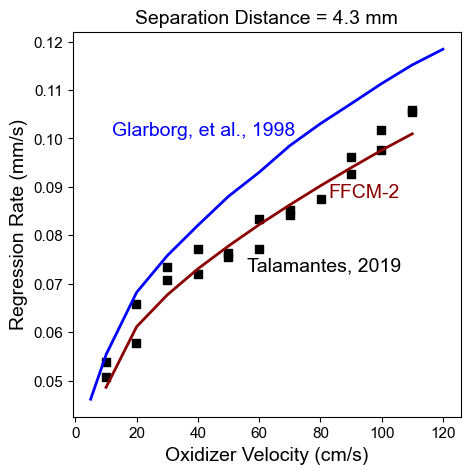

In [4]:
# load regression rate data in Fig.26 of the thesis
paper_df = pd.read_excel("T2019_Fig26.xlsx")
paper_oxi_vel_expt = np.array(paper_df["Oxi_Vel_Expt (cm/s)"])
paper_rb_expt = np.array(paper_df["rb_Expt (mm/s)"])
paper_oxi_vel_num = np.array(paper_df["Oxi_Vel_Num (cm/s)"])
paper_rb_num = np.array(paper_df["rb_Num (mm/s)"])

# plot experiment data, simulation result in the thesis, and simulation result above
plt.scatter(paper_oxi_vel_expt, paper_rb_expt, color="k", marker="s", label="Paper Expt.")
plt.plot(paper_oxi_vel_num, paper_rb_num, color="b", label="Paper Model")
plt.plot(np.loadtxt("oxi_vel.txt") * 1e2, np.loadtxt("rb.txt") * 1e3, color="darkred", label="FFCM2")

# set axis and title labels
plt.xlabel("Oxidizer Velocity (cm/s)")
plt.ylabel("Regression Rate (mm/s)")
plt.title("Separation Distance = 4.3 mm")

# set legends
plt.text(0.45, 0.38, "Talamantes, 2019", transform=plt.gca().transAxes, color="k")
plt.text(0.1, 0.73, "Glarborg, et al., 1998", transform=plt.gca().transAxes, color="b")
plt.text(0.66, 0.57, "FFCM-2", transform=plt.gca().transAxes, color="darkred")

# save figure
plt.savefig("rb_oxi_vel.png", bbox_inches="tight")